In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 1.0 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)

    # Output, class prediction
    fc3 = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    print(fc3.shape)
    return fc3

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # 3x4 conv, 64 inputs, 32 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 64, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # 512 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([512, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bc4': tf.Variable(tf.random_normal([32])),
    'bc5': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 3, 4, 64)
(?, 3, 4, 32)
(?, 2, 2, 64)
(?, 1024)
(?, 512)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 456017344.000000, Accuracy = 0.315999984741
Performance on test set: Training epochs #1000, Batch Loss = 423604128.0, Accuracy = 0.101999998093
Training epochs #20000: Batch Loss = 217826336.000000, Accuracy = 0.0
Performance on test set: Training epochs #20000, Batch Loss = 63510036.0, Accuracy = 0.0
Training epochs #40000: Batch Loss = 46875884.000000, Accuracy = 0.821000099182
Performance on test set: Training epochs #40000, Batch Loss = 45370404.0, Accuracy = 0.81099998951
Training epochs #60000: Batch Loss = 28483742.000000, Accuracy = 0.808999955654
Performance on test set: Training epochs #60000, Batch Loss = 27671444.0, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 12751152.000000, Accuracy = 0.819999933243
Performance on test set: Training epochs #80000, Batch Loss = 12267736.0, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 51561884.000000, Accuracy = 0.370000034571
Performance on test set: Training epochs 

Training epochs #920000: Batch Loss = 479983.843750, Accuracy = 0.972999989986
Performance on test set: Training epochs #920000, Batch Loss = 460408.1875, Accuracy = 0.963999986649
Training epochs #940000: Batch Loss = 141653.906250, Accuracy = 0.98400002718
Performance on test set: Training epochs #940000, Batch Loss = 84038.4609375, Accuracy = 0.985000014305
Training epochs #960000: Batch Loss = 8878.039062, Accuracy = 0.997000098228
Performance on test set: Training epochs #960000, Batch Loss = 15031.9082031, Accuracy = 0.994000077248
Training epochs #980000: Batch Loss = 2224151.750000, Accuracy = 0.565999984741
Performance on test set: Training epochs #980000, Batch Loss = 4279866.5, Accuracy = 0.170000001788
Training epochs #1000000: Batch Loss = 410170.656250, Accuracy = 0.975000023842
Performance on test set: Training epochs #1000000, Batch Loss = 389782.90625, Accuracy = 0.96799993515
Training epochs #1020000: Batch Loss = 122414.632812, Accuracy = 0.974000036716
Performance o

Training epochs #1820000: Batch Loss = 483291.218750, Accuracy = 0.971000015736
Performance on test set: Training epochs #1820000, Batch Loss = 443484.46875, Accuracy = 0.970999956131
Training epochs #1840000: Batch Loss = 20569.722656, Accuracy = 0.997000098228
Performance on test set: Training epochs #1840000, Batch Loss = 40063.3984375, Accuracy = 0.993000030518
Training epochs #1860000: Batch Loss = 208232.437500, Accuracy = 0.94000005722
Performance on test set: Training epochs #1860000, Batch Loss = 5593422.5, Accuracy = 0.194999992847
Training epochs #1880000: Batch Loss = 1382795.125000, Accuracy = 0.963999986649
Performance on test set: Training epochs #1880000, Batch Loss = 1376011.125, Accuracy = 0.954999983311
Training epochs #1900000: Batch Loss = 615801.875000, Accuracy = 0.973000049591
Performance on test set: Training epochs #1900000, Batch Loss = 509943.5, Accuracy = 0.962000012398
Training epochs #1920000: Batch Loss = 61770.257812, Accuracy = 0.986999988556
Performan

Training epochs #2740000: Batch Loss = 345938.468750, Accuracy = 0.927000045776
Performance on test set: Training epochs #2740000, Batch Loss = 11968574.0, Accuracy = 0.0520000047982
Training epochs #2760000: Batch Loss = 1530442.250000, Accuracy = 0.963999986649
Performance on test set: Training epochs #2760000, Batch Loss = 1409190.375, Accuracy = 0.962000012398
Training epochs #2780000: Batch Loss = 863932.312500, Accuracy = 0.972000002861
Performance on test set: Training epochs #2780000, Batch Loss = 855942.125, Accuracy = 0.970999956131
Training epochs #2800000: Batch Loss = 394374.312500, Accuracy = 0.983000040054
Performance on test set: Training epochs #2800000, Batch Loss = 465538.65625, Accuracy = 0.971000015736
Training epochs #2820000: Batch Loss = 822238.625000, Accuracy = 0.946000039577
Performance on test set: Training epochs #2820000, Batch Loss = 4997842.5, Accuracy = 0.188999980688
Training epochs #2840000: Batch Loss = 1453566.500000, Accuracy = 0.964000046253
Perfo

Training epochs #3660000: Batch Loss = 163738.921875, Accuracy = 0.983999967575
Performance on test set: Training epochs #3660000, Batch Loss = 127173.421875, Accuracy = 0.985999941826
Training epochs #3680000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #3680000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #3700000: Batch Loss = 116364.507812, Accuracy = 0.966000080109
Performance on test set: Training epochs #3700000, Batch Loss = 515638.1875, Accuracy = 0.054999999702
Training epochs #3720000: Batch Loss = 106022.664062, Accuracy = 0.972999989986
Performance on test set: Training epochs #3720000, Batch Loss = 236323.09375, Accuracy = 0.961000025272
Training epochs #3740000: Batch Loss = 92564.328125, Accuracy = 0.995000004768
Performance on test set: Training epochs #3740000, Batch Loss = 27425.3164062, Accuracy = 0.996000051498
Training epochs #3760000: Batch Loss = 3201.868164, Accuracy = 0.998000085354
Performance on test set: Tra

Training epochs #4580000: Batch Loss = 1947933.625000, Accuracy = 0.694999992847
Performance on test set: Training epochs #4580000, Batch Loss = 14806799.0, Accuracy = 0.0510000064969
Training epochs #4600000: Batch Loss = 1330713.375000, Accuracy = 0.972999989986
Performance on test set: Training epochs #4600000, Batch Loss = 1301829.625, Accuracy = 0.961000025272
Training epochs #4620000: Batch Loss = 928113.187500, Accuracy = 0.972000002861
Performance on test set: Training epochs #4620000, Batch Loss = 901461.25, Accuracy = 0.971000015736
Training epochs #4640000: Batch Loss = 359656.281250, Accuracy = 0.983999967575
Performance on test set: Training epochs #4640000, Batch Loss = 409832.03125, Accuracy = 0.978999972343
Training epochs #4660000: Batch Loss = 704075.125000, Accuracy = 0.958000123501
Performance on test set: Training epochs #4660000, Batch Loss = 1152924.375, Accuracy = 0.18900001049
Training epochs #4680000: Batch Loss = 256924.000000, Accuracy = 0.976999998093
Perfo

Training epochs #5500000: Batch Loss = 200410.750000, Accuracy = 0.973000109196
Performance on test set: Training epochs #5500000, Batch Loss = 126743.640625, Accuracy = 0.975000023842
Training epochs #5520000: Batch Loss = 7375.554199, Accuracy = 0.997000098228
Performance on test set: Training epochs #5520000, Batch Loss = 11306.7246094, Accuracy = 0.994000077248
Training epochs #5540000: Batch Loss = 383761.000000, Accuracy = 0.9390001297
Performance on test set: Training epochs #5540000, Batch Loss = 19499348.0, Accuracy = 0.0520000010729
Training epochs #5560000: Batch Loss = 1825240.500000, Accuracy = 0.95199996233
Performance on test set: Training epochs #5560000, Batch Loss = 2057210.5, Accuracy = 0.942999958992
Training epochs #5580000: Batch Loss = 1744507.750000, Accuracy = 0.959000110626
Performance on test set: Training epochs #5580000, Batch Loss = 1645853.625, Accuracy = 0.961000025272
Training epochs #5600000: Batch Loss = 457044.031250, Accuracy = 0.980000019073
Perfor

Training epochs #6420000: Batch Loss = 822584.812500, Accuracy = 0.934000074863
Performance on test set: Training epochs #6420000, Batch Loss = 2984377.75, Accuracy = 0.054999999702
Training epochs #6440000: Batch Loss = 337075.625000, Accuracy = 0.9849999547
Performance on test set: Training epochs #6440000, Batch Loss = 365551.625, Accuracy = 0.976000010967
Training epochs #6460000: Batch Loss = 179747.328125, Accuracy = 0.975000023842
Performance on test set: Training epochs #6460000, Batch Loss = 140538.234375, Accuracy = 0.977000057697
Training epochs #6480000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #6480000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6500000: Batch Loss = 32211.332031, Accuracy = 0.990000069141
Performance on test set: Training epochs #6500000, Batch Loss = 888496.25, Accuracy = 0.194999992847
Training epochs #6520000: Batch Loss = 438095.625000, Accuracy = 0.966000080109
Performance on test set: 

Training epochs #7340000: Batch Loss = 913834.250000, Accuracy = 0.983999967575
Performance on test set: Training epochs #7340000, Batch Loss = 892212.9375, Accuracy = 0.980000019073
Training epochs #7360000: Batch Loss = 453193.437500, Accuracy = 0.98400002718
Performance on test set: Training epochs #7360000, Batch Loss = 473671.5625, Accuracy = 0.980000019073
Training epochs #7380000: Batch Loss = 1343474.250000, Accuracy = 0.820999979973
Performance on test set: Training epochs #7380000, Batch Loss = 1071134.125, Accuracy = 0.860000014305
Training epochs #7400000: Batch Loss = 80642.531250, Accuracy = 0.982000112534
Performance on test set: Training epochs #7400000, Batch Loss = 57985.0, Accuracy = 0.988000094891
Training epochs #7420000: Batch Loss = 223737.093750, Accuracy = 0.980999946594
Performance on test set: Training epochs #7420000, Batch Loss = 114093.984375, Accuracy = 0.982000112534
Training epochs #7440000: Batch Loss = 21267.015625, Accuracy = 0.997000098228
Performan

Training epochs #8260000: Batch Loss = 87889.062500, Accuracy = 0.977999985218
Performance on test set: Training epochs #8260000, Batch Loss = 1541039.125, Accuracy = 0.194999992847
Training epochs #8280000: Batch Loss = 98317.257812, Accuracy = 0.987000048161
Performance on test set: Training epochs #8280000, Batch Loss = 362017.25, Accuracy = 0.975000023842
Training epochs #8300000: Batch Loss = 349450.125000, Accuracy = 0.974000036716
Performance on test set: Training epochs #8300000, Batch Loss = 259729.609375, Accuracy = 0.975000023842
Training epochs #8320000: Batch Loss = 35660.351562, Accuracy = 0.997000038624
Performance on test set: Training epochs #8320000, Batch Loss = 54206.1953125, Accuracy = 0.996000051498
Training epochs #8340000: Batch Loss = 167576.203125, Accuracy = 0.875
Performance on test set: Training epochs #8340000, Batch Loss = 4485003.0, Accuracy = 0.18900001049
Training epochs #8360000: Batch Loss = 331313.531250, Accuracy = 0.979000091553
Performance on tes

Training epochs #9180000: Batch Loss = 796799.000000, Accuracy = 0.981000006199
Performance on test set: Training epochs #9180000, Batch Loss = 732902.0625, Accuracy = 0.985000014305
Training epochs #9200000: Batch Loss = 330220.375000, Accuracy = 0.986999988556
Performance on test set: Training epochs #9200000, Batch Loss = 345113.0, Accuracy = 0.985000014305
Training epochs #9220000: Batch Loss = 629426.687500, Accuracy = 0.946000039577
Performance on test set: Training epochs #9220000, Batch Loss = 5415808.0, Accuracy = 0.0550000034273
Training epochs #9240000: Batch Loss = 317755.156250, Accuracy = 0.986000061035
Performance on test set: Training epochs #9240000, Batch Loss = 321929.8125, Accuracy = 0.986000001431
Training epochs #9260000: Batch Loss = 159269.437500, Accuracy = 0.983999967575
Performance on test set: Training epochs #9260000, Batch Loss = 127097.203125, Accuracy = 0.985999941826
Training epochs #9280000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance o

Training epochs #10100000: Batch Loss = 212387.937500, Accuracy = 0.961000025272
Performance on test set: Training epochs #10100000, Batch Loss = 133152.78125, Accuracy = 0.865999996662
Training epochs #10120000: Batch Loss = 4085.544189, Accuracy = 0.998000085354
Performance on test set: Training epochs #10120000, Batch Loss = 6668.89257812, Accuracy = 0.996999979019
Training epochs #10140000: Batch Loss = 77516.531250, Accuracy = 0.995999932289
Performance on test set: Training epochs #10140000, Batch Loss = 9696.56152344, Accuracy = 0.996999979019
Training epochs #10160000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #10160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10180000: Batch Loss = 656717.687500, Accuracy = 0.81400001049
Performance on test set: Training epochs #10180000, Batch Loss = 5615578.0, Accuracy = 0.0520000010729
Training epochs #10200000: Batch Loss = 290814.593750, Accuracy = 0.976999938488
Performan

Training epochs #11020000: Batch Loss = 73390.484375, Accuracy = 0.996000051498
Performance on test set: Training epochs #11020000, Batch Loss = 8232.51074219, Accuracy = 0.994000077248
Training epochs #11040000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #11040000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #11060000: Batch Loss = 1011197.125000, Accuracy = 0.695000052452
Performance on test set: Training epochs #11060000, Batch Loss = 6217237.0, Accuracy = 0.192000001669
Training epochs #11080000: Batch Loss = 376270.593750, Accuracy = 0.991000115871
Performance on test set: Training epochs #11080000, Batch Loss = 256414.59375, Accuracy = 0.991000056267
Training epochs #11100000: Batch Loss = 308874.187500, Accuracy = 0.98400002718
Performance on test set: Training epochs #11100000, Batch Loss = 257179.96875, Accuracy = 0.985000014305
Training epochs #11120000: Batch Loss = 101022.109375, Accuracy = 0.997000098228
Performance on tes

Training epochs #11920000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #11920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11940000: Batch Loss = 907978.125000, Accuracy = 0.824000060558
Performance on test set: Training epochs #11940000, Batch Loss = 2436054.0, Accuracy = 0.186000004411
Training epochs #11960000: Batch Loss = 319451.562500, Accuracy = 0.985999941826
Performance on test set: Training epochs #11960000, Batch Loss = 323565.5, Accuracy = 0.986000001431
Training epochs #11980000: Batch Loss = 109554.851562, Accuracy = 0.98299998045
Performance on test set: Training epochs #11980000, Batch Loss = 62438.1484375, Accuracy = 0.985999941826
Training epochs #12000000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #12000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12020000: Batch Loss = 111172.156250, Accuracy = 0.984000086784
Performance on test set: Tra

Training epochs #12840000: Batch Loss = 37135.640625, Accuracy = 0.178999990225
Performance on test set: Training epochs #12840000, Batch Loss = 9111.78808594, Accuracy = 0.993000030518
Training epochs #12860000: Batch Loss = 377335.906250, Accuracy = 0.9849999547
Performance on test set: Training epochs #12860000, Batch Loss = 349523.71875, Accuracy = 0.986000001431
Training epochs #12880000: Batch Loss = 110526.421875, Accuracy = 0.986999928951
Performance on test set: Training epochs #12880000, Batch Loss = 105930.140625, Accuracy = 0.986000001431
Training epochs #12900000: Batch Loss = 421027.312500, Accuracy = 0.851999998093
Performance on test set: Training epochs #12900000, Batch Loss = 1569226.625, Accuracy = 0.8599999547
Training epochs #12920000: Batch Loss = 41765.050781, Accuracy = 0.990000009537
Performance on test set: Training epochs #12920000, Batch Loss = 71131.21875, Accuracy = 0.985000014305
Training epochs #12940000: Batch Loss = 192337.218750, Accuracy = 0.97899997

Training epochs #13780000: Batch Loss = 68961.562500, Accuracy = 0.990000009537
Performance on test set: Training epochs #13780000, Batch Loss = 4343414.5, Accuracy = 0.0550000034273
Training epochs #13800000: Batch Loss = 564472.000000, Accuracy = 0.975000023842
Performance on test set: Training epochs #13800000, Batch Loss = 534363.75, Accuracy = 0.976999998093
Training epochs #13820000: Batch Loss = 159658.015625, Accuracy = 0.981999993324
Performance on test set: Training epochs #13820000, Batch Loss = 116420.40625, Accuracy = 0.979999959469
Training epochs #13840000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #13840000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #13860000: Batch Loss = 29581.169922, Accuracy = 0.996000051498
Performance on test set: Training epochs #13860000, Batch Loss = 10706895.0, Accuracy = 0.194999992847
Training epochs #13880000: Batch Loss = 264682.562500, Accuracy = 0.972999989986
Performance on test set:

Training epochs #14700000: Batch Loss = 10057.293945, Accuracy = 0.997000098228
Performance on test set: Training epochs #14700000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14720000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14740000: Batch Loss = 20964.052734, Accuracy = 0.996000051498
Performance on test set: Training epochs #14740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14760000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14760000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14780000: Batch Loss = 1112.563110, Accuracy = 0.999000072479
Performance on test set: Training epochs #14780000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14800000: Batch Loss = 0.000000, Accuracy = 1.0
Performance on test set: Training epochs #14800000, Batch Loss = 0.0, A

Training epochs #15640000: Batch Loss = 218853.515625, Accuracy = 0.991000056267
Performance on test set: Training epochs #15640000, Batch Loss = 145399.15625, Accuracy = 0.994000077248
Training epochs #15660000: Batch Loss = 169531.125000, Accuracy = 0.994000077248
Performance on test set: Training epochs #15660000, Batch Loss = 88865.1015625, Accuracy = 0.994000077248
Training epochs #15680000: Batch Loss = 29457.957031, Accuracy = 0.997000098228
Performance on test set: Training epochs #15680000, Batch Loss = 56264.3671875, Accuracy = 0.994000077248
Training epochs #15700000: Batch Loss = 162999.625000, Accuracy = 0.730999946594
Performance on test set: Training epochs #15700000, Batch Loss = 582.85546875, Accuracy = 0.995000123978
Training epochs #15720000: Batch Loss = 224013.750000, Accuracy = 0.98400002718
Performance on test set: Training epochs #15720000, Batch Loss = 234765.78125, Accuracy = 0.983000040054
Training epochs #15740000: Batch Loss = 38493.894531, Accuracy = 0.983

# performance visualization

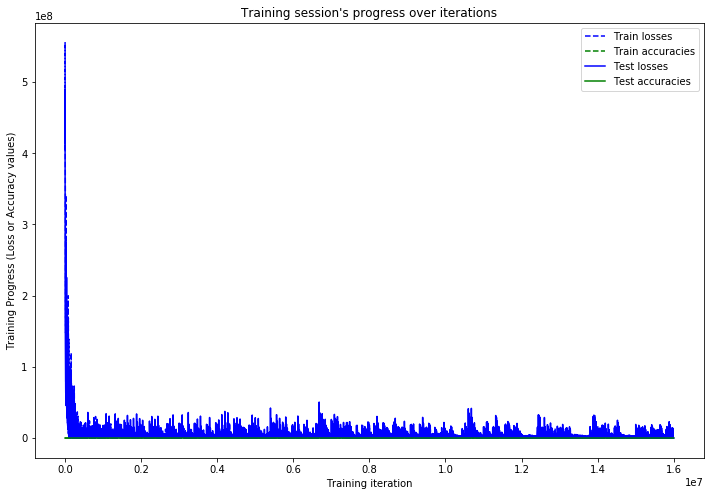

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 93.2651269898%
Recall: 92.725%
f1_score: 91.6227852971%

Confusion Matrix:
[[    0     0     0     0     0     7     1    10     0     0     0     0
      0]
 [    0   183     0     0    73    87   235   250     0    19     0    64
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     2
      0]
 [    0     0     0     0  2798     3    35    20     0     0     0    35
      0]
 [    0     0     0     0     5   277    25    40     0     0     0     1
      0]
 [    0     0     0     0     0     0 14486     0     0     7     0     2
      0]
 [    0     0     0     0    34   312    88    67     0     0     0    34
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     2     0     2
      0]
 [    0     0     0     0     0     0     0  

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


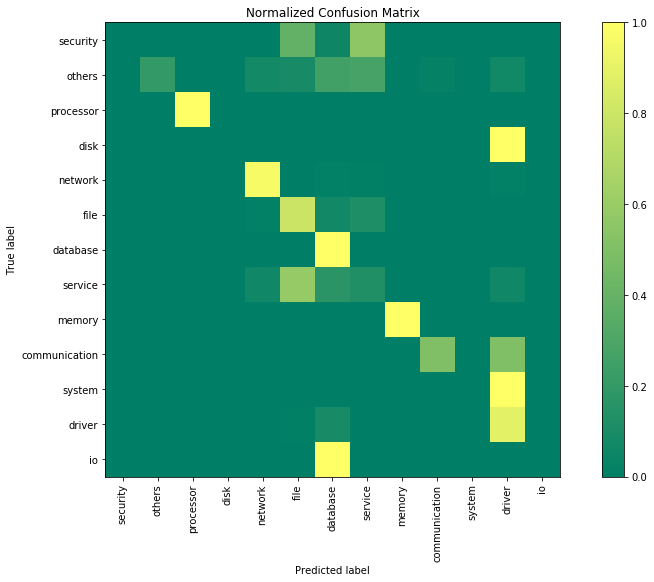

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)